>[Importing Libraries](#scrollTo=ZXkr7lOkUKmi)

>[Loading Dataset](#scrollTo=KXnXXj9qT-ss)

>[Model](#scrollTo=HU8O-31wT-sx)

>[Result](#scrollTo=r8fZEPtxT-sy)



# Importing Libraries


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Loading Dataset

In [2]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])


data = pd.DataFrame(data, columns = ['image_file', 'label'])

data['path'] = path + '/' +data['image_file']
data['label'] = data['label'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()


,image_file,label,path
0,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-158.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-10121.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-1811.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-97.png,Normal,../input/covid19-radiography-database/COVID-19...


In [3]:
data.describe()

,image_file,label,path
count,21165,21165,21165
unique,21165,4,21165
top,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
freq,1,10192,1


In [4]:
no_of_samples = 21165
df = pd.DataFrame()
df['label'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [len(data[data['label'] == 'Normal']),
               len(data[data['label'] == 'Covid_positive']),
               len(data[data['label'] == 'Lung_Opacity']),
               len(data[data['label'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'label', y = 'Count',
             color = "label",  width = 600,
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [5]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

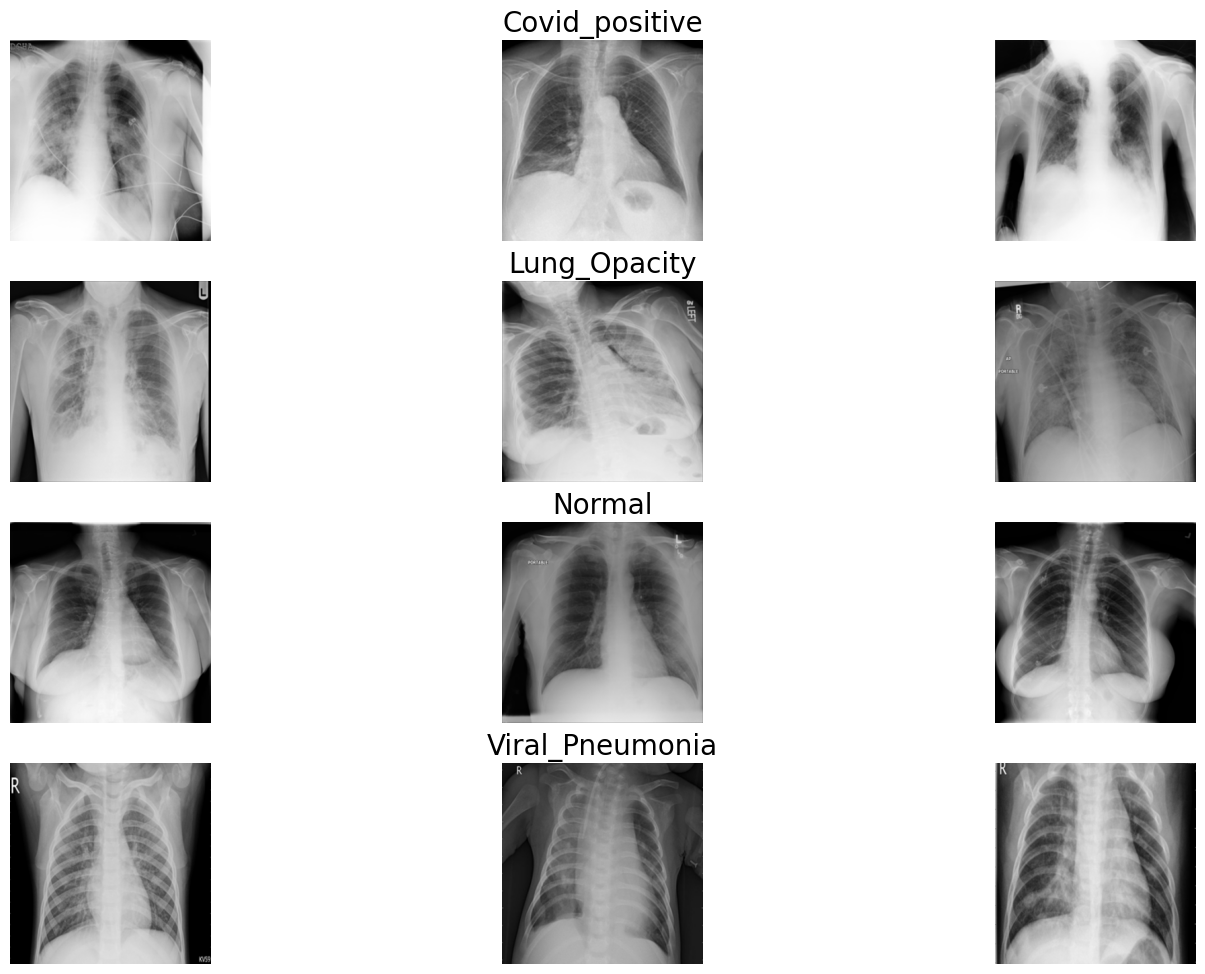

In [6]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['label']).groupby('label')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [7]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])  
    image = cv2.resize(image, (100, 100)) / 255.0
    label = 0
    if data['label'][i] == "Covid_positive":
        label = 0
    else:
        label = 1
    all_data.append([image, label])


In [8]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array
x = np.array(x)
y = np.array(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size=0.5, random_state=42)


print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(16932, 100, 100, 3) (2117, 100, 100, 3) (2116, 100, 100, 3) (16932,) (2117,) (2116,)


# Model

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization

model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(2, activation='softmax'))


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 64)       2

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



530/530 [==============================] - 329s 614ms/step - loss: 0.5019 - accuracy: 0.8505 - val_loss: 0.9112 - val_accuracy: 0.7256
Epoch 2/10
530/530 [==============================] - 329s 621ms/step - loss: 0.2666 - accuracy: 0.8833 - val_loss: 0.2214 - val_accuracy: 0.9140
Epoch 3/10
530/530 [==============================] - 317s 598ms/step - loss: 0.2153 - accuracy: 0.9127 - val_loss: 0.2522 - val_accuracy: 0.8932
Epoch 4/10
530/530 [==============================] - 320s 604ms/step - loss: 0.1838 - accuracy: 0.9249 - val_loss: 0.1524 - val_accuracy: 0.9410
Epoch 5/10
530/530 [==============================] - 320s 603ms/step - loss: 0.1652 - accuracy: 0.9354 - val_loss: 0.1168 - val_accuracy: 0.9636
Epoch 6/10
530/530 [==============================] - 315s 594ms/step - loss: 0.1390 - accuracy: 0.9493 - val_loss: 0.1473 - val_accuracy: 0.9480
Epoch 7/10
530/530 [==============================] - 311s 587ms/step - loss: 0.1294 - accuracy: 0.9508 - val_loss: 0.3959 - val_accura

In [12]:
model.save('/kaggle/working/')

In [13]:
model.save('model.h5')

# Result

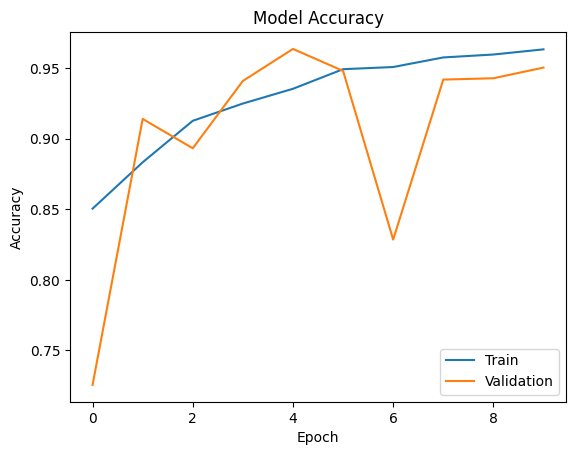

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

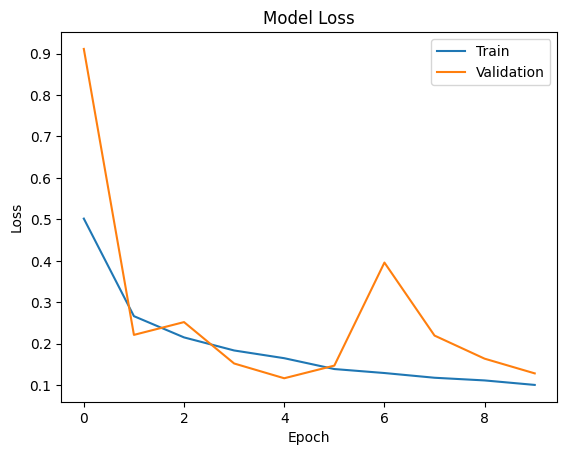

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

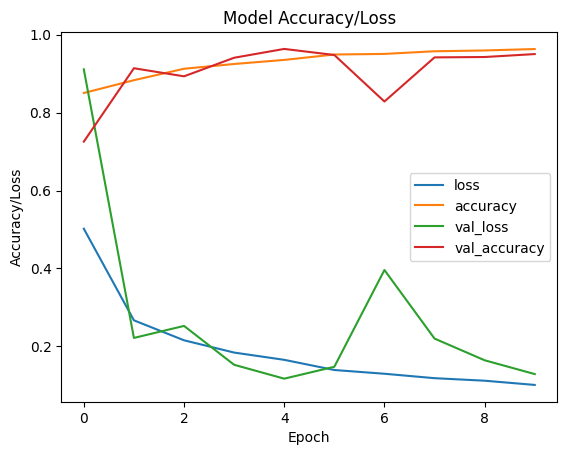

In [16]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

67/67 [==============================] - 11s 168ms/step
Accuracy: 0.9499054820415879
Precision: 0.9536348691984423
Recall: 0.9499054820415879
Confusion Matrix:
[[ 326   30]
 [  76 1684]]


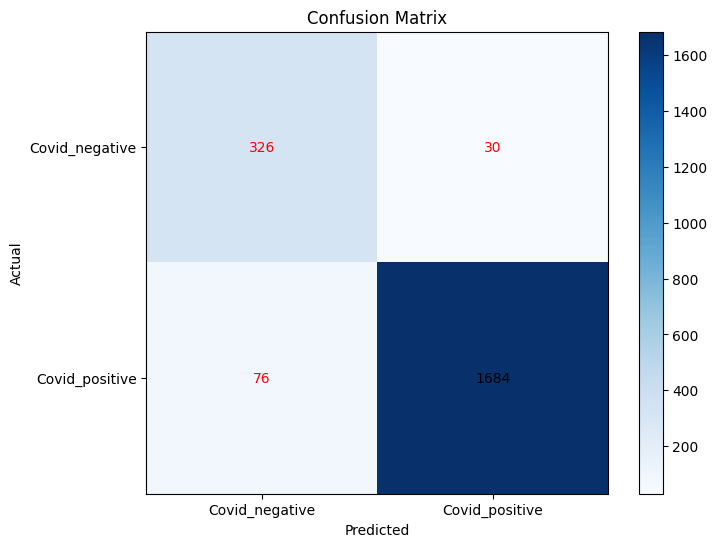

Percentage Confusion Matrix:
[[0.91573034 0.08426966]
 [0.04318182 0.95681818]]


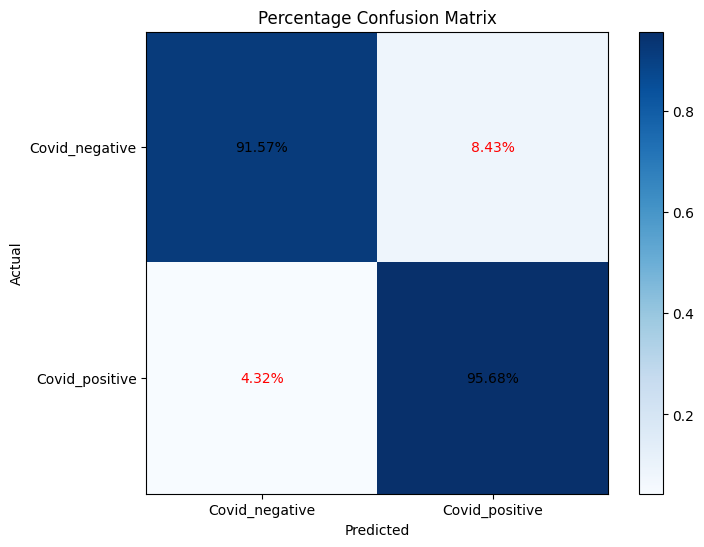

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Make predictions on the test set
y_pred_one_hot = model.predict(x_val)
y_pred = np.argmax(y_pred_one_hot, axis=1)  # Convert one-hot predictions to class labels

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(2), labels=['Covid_negative','Covid_positive',])
plt.yticks(np.arange(2), labels=['Covid_negative','Covid_positive',])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'black')
plt.show()


# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Compute the percentage confusion matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Print the percentage confusion matrix with class labels
print("Percentage Confusion Matrix:")
print(conf_matrix_percentage)

# Plot the percentage confusion matrix with class labels
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Percentage Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(2), labels=['Covid_negative','Covid_positive'])
plt.yticks(np.arange(2), labels=['Covid_negative','Covid_positive'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix_percentage[i, j]*100:.2f}%', ha='center', va='center', color='red' if conf_matrix_percentage[i, j] < 0.5 else 'black')
plt.show()